<a href="https://colab.research.google.com/github/palinkapro/RS_check/blob/master/clustering_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, v_measure_score, confusion_matrix
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap

np.random.seed(42)

In [2]:
X, y = load_digits(n_class=10, return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

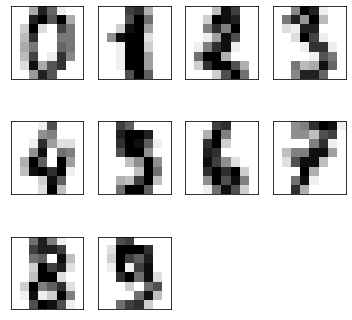

In [3]:
X_img = X.reshape(-1, 8, 8)

fig = plt.figure(figsize=(6, 6))  

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X_img[i], cmap=plt.cm.binary, interpolation='none')

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [4]:
model_1 = AgglomerativeClustering(n_clusters=10)
clusters_1 = model_1.fit_predict(X)

model_2 = KMeans(n_clusters=10, n_init=100)
clusters_2 = model_2.fit_predict(X)

clusters_1.shape, clusters_2.shape

((1797,), (1797,))

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [5]:
# function for visualizing digits

def plot_digits(img_data, predict):
  fig = plt.figure(figsize=(6, 6))  

  for i in range(10):
      mask = (predict == i)
      ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
      ax.imshow(img_data[mask].mean(axis=0), cmap=plt.cm.binary, interpolation='none')

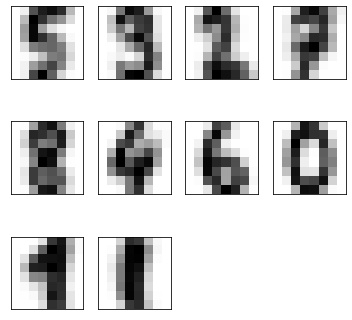

In [6]:
# cluster centers of AgglomerativeClustering

plot_digits(X_img, clusters_1)

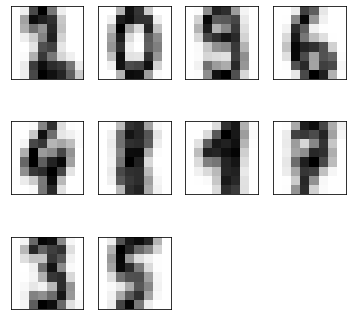

In [7]:
# cluster centers of KMeans
plot_digits(X_img, clusters_2)


__________
На примере данного датасета алгоритм KMeans дает более четкие и распознаваемые очертания цифр, а в случае с Agglomerative clustering есть предположение, что несколько различных цифр попадают в один кластер - в следствие чего усредненные изображения выглядят более размытыми.
__________





В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

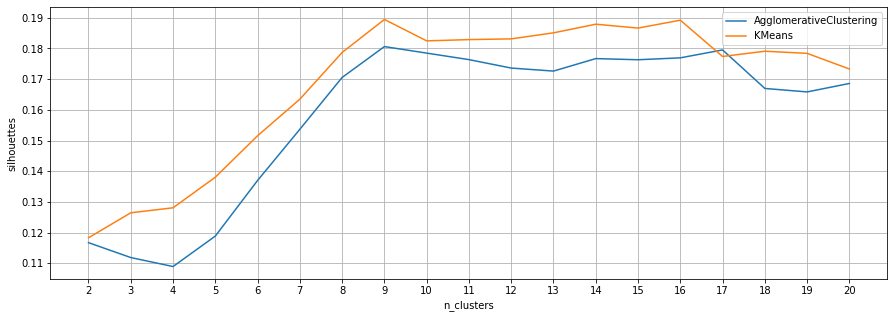

In [8]:
cluster_numbers = range(2, 21)
silhouettes_1 = []
silhouettes_2 = []

for i in cluster_numbers:
    silhouettes_1.append(silhouette_score(X, AgglomerativeClustering(n_clusters=i).fit_predict(X)))
    silhouettes_2.append(silhouette_score(X, KMeans(n_clusters=i, n_init=100).fit_predict(X)))

plt.figure(figsize=(15,5))
plt.plot(cluster_numbers, silhouettes_1, label='AgglomerativeClustering')
plt.plot(cluster_numbers, silhouettes_2, label='KMeans')
plt.xticks(np.arange(2, 21))
plt.grid()
plt.xlabel('n_clusters')
plt.ylabel('silhouettes')
plt.legend()
plt.show()

In [9]:
print(f'AgglomerativeClustering: максимум силуэта:  {max(silhouettes_1):.4f} достигается при количестве кластеров равном: {cluster_numbers[np.argmax(silhouettes_1)]}')
print(f'KMeans:                  максимум силуэта:  {max(silhouettes_2):.4f} достигается при количестве кластеров равном: {cluster_numbers[np.argmax(silhouettes_2)]}') 

AgglomerativeClustering: максимум силуэта:  0.1806 достигается при количестве кластеров равном: 9
KMeans:                  максимум силуэта:  0.1895 достигается при количестве кластеров равном: 9


Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

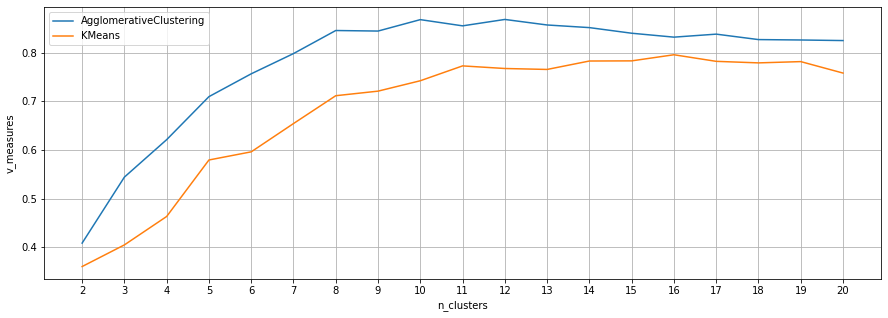

In [10]:
v_measure_1 = []
v_measure_2 = []

for i in cluster_numbers:
    v_measure_1.append(v_measure_score(y, AgglomerativeClustering(n_clusters=i).fit_predict(X)))
    v_measure_2.append(v_measure_score(y, KMeans(n_clusters=i, n_init=100).fit_predict(X)))
    
plt.figure(figsize=(15,5))
plt.plot(cluster_numbers, v_measure_1, label='AgglomerativeClustering')
plt.plot(cluster_numbers, v_measure_2, label='KMeans')
plt.xticks(np.arange(2, 21))
plt.grid()
plt.xlabel('n_clusters')
plt.ylabel('v_measures')
plt.legend()
plt.show()

In [11]:
print(f'AgglomerativeClustering: максимум v-меры:  {max(v_measure_1):.4f} достигается при количестве кластеров равном: {cluster_numbers[np.argmax(v_measure_1)]}')
print(f'KMeans:                  максимум v-меры:  {max(v_measure_2):.4f} достигается при количестве кластеров равном: {cluster_numbers[np.argmax(v_measure_2)]}') 

AgglomerativeClustering: максимум v-меры:  0.8685 достигается при количестве кластеров равном: 12
KMeans:                  максимум v-меры:  0.7959 достигается при количестве кластеров равном: 16


# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

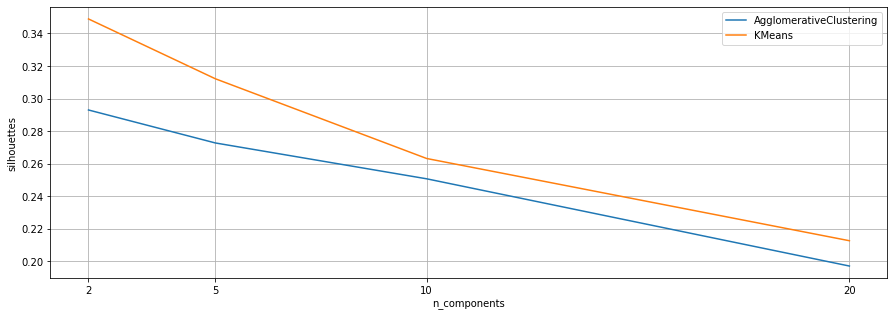

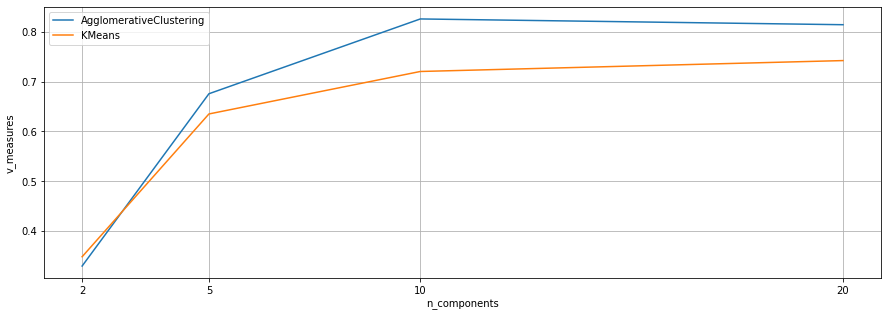

In [12]:
silhouettes_1 = []
silhouettes_2 = []
v_measure_1 = []
v_measure_2 = []
n_comp = [2, 5, 10, 20]

for i in n_comp:
    X_svd = TruncatedSVD(n_components=i).fit_transform(X)
    silhouettes_1.append(silhouette_score(X_svd, model_1.fit_predict(X_svd)))
    silhouettes_2.append(silhouette_score(X_svd, model_2.fit_predict(X_svd)))
    v_measure_1.append(v_measure_score(y, model_1.fit_predict(X_svd)))
    v_measure_2.append(v_measure_score(y, model_2.fit_predict(X_svd)))
    
plt.figure(figsize=(15,5))
plt.plot(n_comp, silhouettes_1, label='AgglomerativeClustering')
plt.plot(n_comp, silhouettes_2, label='KMeans')
plt.xticks([2, 5, 10, 20])
plt.grid()
plt.xlabel('n_components')
plt.ylabel('silhouettes')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(n_comp, v_measure_1, label='AgglomerativeClustering')
plt.plot(n_comp, v_measure_2, label='KMeans')
plt.xticks([2, 5, 10, 20])
plt.grid()
plt.xlabel('n_components')
plt.ylabel('v_measures')
plt.legend()
plt.show()

__________
При снижении количества признаков до 2-х удалось увеличить значение силуэта до 0.35 при использовании алгоритма KMeans. Значения v-меры немного ниже максимально достигнутых на исходных данных без применения снижения размерности.
__________


In [13]:
print('Алгоритм                    Метрика     Значение     n_признаков')
print('-'*70)
print(f'AgglomerativeClustering     силуэт       {max(silhouettes_1):.4f}             {n_comp[np.argmax(silhouettes_1)]}')
print(f'                            v-мера       {max(v_measure_1):.4f}            {n_comp[np.argmax(v_measure_1)]}')
print(f'KMeans                      силуэт       {max(silhouettes_2):.4f}             {n_comp[np.argmax(silhouettes_2)]}') 
print(f'                            v-мера       {max(v_measure_2):.4f}            {n_comp[np.argmax(v_measure_2)]}') 

Алгоритм                    Метрика     Значение     n_признаков
----------------------------------------------------------------------
AgglomerativeClustering     силуэт       0.2930             2
                            v-мера       0.8260            10
KMeans                      силуэт       0.3489             2
                            v-мера       0.7423            20


Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [14]:
X_tsne = TSNE().fit_transform(X)
X_tsne.shape

(1797, 2)

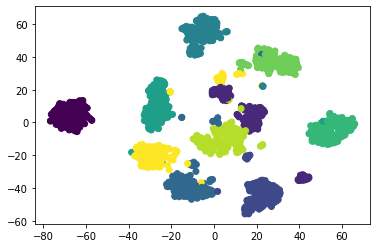

In [15]:
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1], c=y)

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [16]:
sil_agg = silhouette_score(X_tsne, model_1.fit_predict(X_tsne))
sil_km = silhouette_score(X_tsne, model_2.fit_predict(X_tsne))
vm_agg = v_measure_score(y, model_1.fit_predict(X_tsne))
vm_km = v_measure_score(y, model_2.fit_predict(X_tsne))

print('Алгоритм                    Метрика     Значение')
print('-'*70)
print(f'AgglomerativeClustering     силуэт       {sil_agg:.4f}')
print(f'                            v-мера       {vm_agg:.4f}')
print(f'KMeans                      силуэт       {sil_km:.4f}') 
print(f'                            v-мера       {vm_km:.4f}') 

Алгоритм                    Метрика     Значение
----------------------------------------------------------------------
AgglomerativeClustering     силуэт       0.6360
                            v-мера       0.9140
KMeans                      силуэт       0.6344
                            v-мера       0.8996


__________
После применения для снижения размерности алгоритма tSNE удалось существенно улучшить показатели как силуэта так и v-меры в сравнении с исходными данными.
__________

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [17]:
# define a function to arrange cluster numbers and plot confusion matrix
def arr_clust(clusters):
  arr_clusters = np.zeros_like(clusters)
  for i in range(10):
    if np.sum(clusters==i):
      arr_clusters[clusters==i] = np.argmax(np.bincount(y.astype(np.int32)[clusters==i]))
  return arr_clusters

def matrix(target, predict):
  mat = confusion_matrix(target, arr_clust(predict))
  sns.heatmap(mat.T, square=True, annot=True, fmt='d')
  plt.xlabel('true label')
  plt.ylabel('predict label');

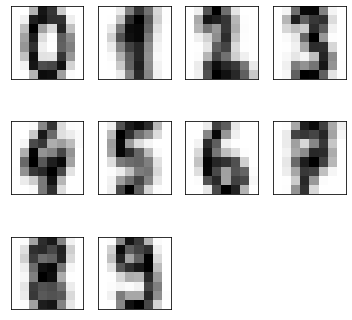

In [18]:
clusters = KMeans(n_clusters=10, n_init=100).fit_predict(X_tsne)
plot_digits(X_img, arr_clust(clusters))

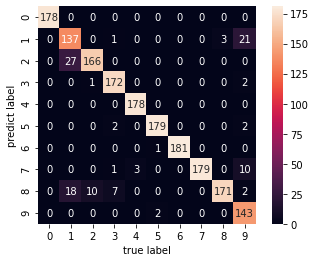

In [19]:
matrix(y, clusters)

__________
Самого лучшего разбиения и в терминах силуэта и v-меры удалось добиться посредством снижения размерности методом tSNE, среди двух алгоритмов кластеризации были получены почти идентичные результаты, для визуализации я выбрала KMeans. При рассмотрении confusion matrix можно сделать вывод, что есть ошибки на цифрах 1 и 9, но в целом большинство кластеров соответствуют истинным значениям.
__________

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

__________
В результате проделанной работы были рассмотрены два алгоритма кластеризации, на примере обработки предоставленных данных можно сделать следующие выводы:


1.   KMeans дает более осмысленные кластеры, в частности при повышении количества инициализаций центроидов до 100. 
2.   Силуэт на данных с большим количеством признаков без понижения размерности не интерпретируем, т.к. он рассчитывает расстояния, а в пространствах большой размерности парные расстояния стремятся к одному и тому же значению и становятся неинформативными.
3.   Качество кластеризации существенно улучшается при снижении размерности признакового пространства, что заметно как по отрисовке центроидов, так и в малом количестве ошибочно определенных кластеров в confusion matrix.








**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [20]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X.shape, y.shape

((70000, 784), (70000,))

In [21]:
# reshaping X for plotting digits

img_data = X.reshape(-1, 28, 28)

# target labels have type object - casting them to int 

y = y.astype(np.int32)

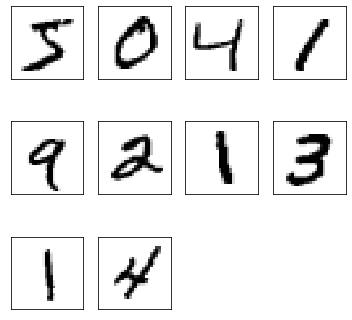

In [22]:
# visualizing digits

fig = plt.figure(figsize=(6, 6))  

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img_data[i], cmap=plt.cm.binary, interpolation='none')

In [23]:
# first attempt - minibatch kmeans

mb_predict = MiniBatchKMeans(n_clusters=10, n_init=100).fit_predict(X)

sil_mb = silhouette_score(X, mb_predict)
vm_mb = v_measure_score(y, mb_predict)
print(f'Silhouette :{sil_mb:.4f}')
print(f'V-measure :{vm_mb:.4f}')

Silhouette :0.0617
V-measure :0.4674


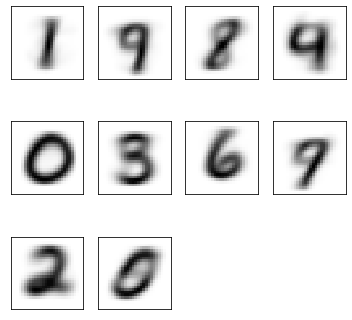

In [24]:
# visualizing cluster centers (digits)

plot_digits(img_data, mb_predict)

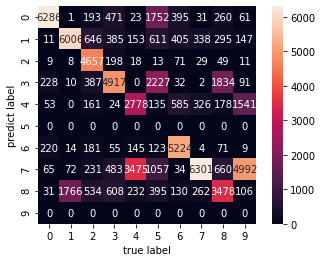

In [25]:
# confusion matrix
matrix(y, mb_predict)

In [26]:
# second attempt - pca

s_data = StandardScaler().fit_transform(X)
pca_data = PCA(n_components=2).fit_transform(X)

pca_predict = KMeans(n_clusters=10, init='k-means++', n_init=100).fit_predict(pca_data)

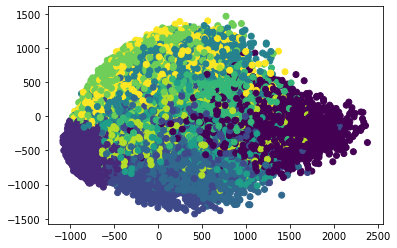

In [27]:
# visualize new data
plt.scatter(x=pca_data[:,0], y=pca_data[:,1], c=y)

In [28]:
# silhouette and v-measure for pca

sil_pca = silhouette_score(pca_data, pca_predict)
vm_pca = v_measure_score(y, pca_predict)
print(f'Silhouette :{sil_pca:.4f}')
print(f'V-measure :{vm_pca:.4f}')

Silhouette :0.3520
V-measure :0.3561


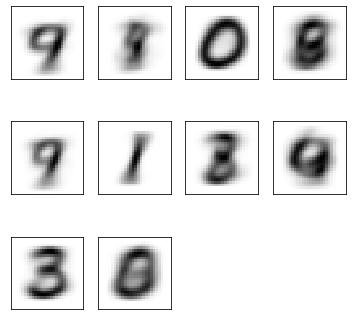

In [29]:
# digits (bad result)
plot_digits(img_data, pca_predict)

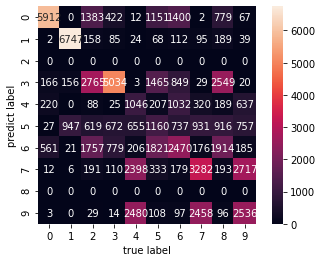

In [30]:
# confusion matrix for pca
matrix(y, pca_predict)

In [31]:
# third attempt umap

umap_data = umap.UMAP(random_state=42).fit_transform(X)

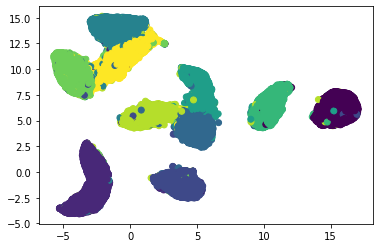

In [32]:
# visualize new data
plt.scatter(x=umap_data[:,0], y=umap_data[:,1], c=y);

In [33]:
umap_predict = KMeans(n_clusters=10, init='k-means++', n_init=100).fit_predict(umap_data)

# silhouette and v-measure for umap

sil_umap = silhouette_score(umap_data, umap_predict)
vm_umap = v_measure_score(y, umap_predict)
print(f'Silhouette :{sil_umap:.4f}')
print(f'V-measure :{vm_umap:.4f}')

Silhouette :0.6177
V-measure :0.8475


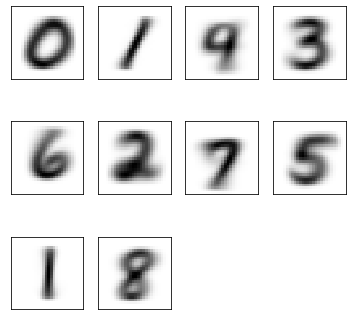

In [34]:
# digits
plot_digits(img_data, umap_predict);

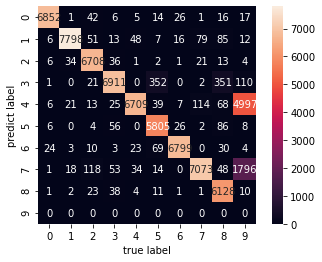

In [35]:
# confusion matrix for umap 

matrix(y, umap_predict)

In [36]:
# fourth attempt - umap and dbscan(plus hyperparameter tuning)

db_umap_data = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)
db_predict = DBSCAN(eps=0.15, min_samples=50).fit_predict(db_umap_data)

In [37]:
# silhouette and v-measure for dbscan

sil_umap = silhouette_score(db_umap_data, db_predict)
vm_umap = v_measure_score(y, db_predict)
print(f'Silhouette :{sil_umap:.4f}')
print(f'V-measure :{vm_umap:.4f}')

Silhouette :0.6433
V-measure :0.9087


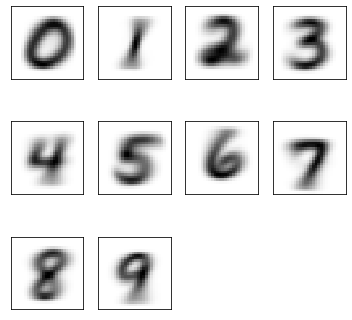

In [38]:
# digits - best result
plot_digits(img_data, arr_clust(db_predict))

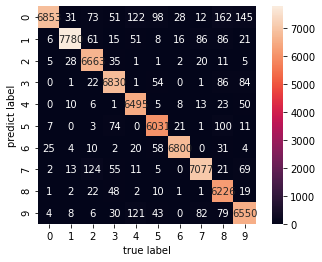

In [39]:
# confusion matrix
matrix(y, db_predict)

__________
Лучшие результаты дал алгоритм DBSCAN в сочетании с методом снижения размерности данных UMAP. Также значения метрик и визуализацию центроидов удалось немного улучшить путем подбора гиперпараметров для двух алгоритмов. Снижение размерности tSNE и иерархическая кластеризация требовали слишком много памяти и вызывали ошибки memory allocation, поэтому в данной работе не были использованы.
Еще был опробован метод поэтапного снижения размерности(сначала PCA, затем tSNE) но сравнимых с лучшими результатов получить не удалось(0.41 силуэт и 0.67 v-мера).
__________